# Commit Chronicle Dataset

This notebook investigates the [Commit Chronicle dataset](https://huggingface.co/datasets/JetBrains-Research/commit-chronicle) introduced in the paper ["From Commit Message Generation to History-Aware Commit Message Completion", ASE 2023](https://arxiv.org/abs/2308.07655) - loading, filtering, EDA and preprocessing

In [1]:
from datasets import load_dataset, load_from_disk
import rootutils
import multiprocessing as mp
from functools import partial

In [ ]:
import sys
sys.path.append('..')
ROOT = rootutils.find_root(".", ".project-root")
OUTPUT_DIR = ROOT / "data/playground"

## Loading and Filtering

Note: Filtering logic is implemented in `CommitChroniclePreprocessor`

In [ ]:
# Run this cell to continue with the rest of this notebook. 

SPLIT = "validation"  # we select this split as it's small for our EDA, feel free to change to `train` split if u want
LANGUAGES = ["Go"]

filtered = OUTPUT_DIR / "01-filtered-validation"


# we don't directly reference `LANGUAGES` in the function because in python multiprocessing,
# all functions passed as parameters shouldn't reference variables outside of them
def filter_dataset(example, languages):
    return example["language"] in languages


if not filtered.exists():
    (
        load_dataset("JetBrains-Research/commit-chronicle", "default", split=SPLIT)
        .filter(partial(filter_dataset, languages=LANGUAGES), num_proc=mp.cpu_count())
        .save_to_disk(filtered)
    )
dataset = load_from_disk(filtered)

In [4]:
dataset.select(range(10))

Dataset({
    features: ['author', 'date', 'timezone', 'hash', 'message', 'mods', 'language', 'license', 'repo', 'original_message'],
    num_rows: 10
})

## EDA

What kind of EDA can we possibly do?

### Column names

These are the columns we have in our dataset and an example of each

In [5]:
print(dataset.column_names) # ['author','date','timezone','hash','message','mods','language','license','repo','original_message']

subset = dataset.select(range(10))

for element in subset:
    print(element)

subset[0]['mods'] # 'Mods' will have multiple changes in different files. need to be appended accordingly. Its length varies.

['author', 'date', 'timezone', 'hash', 'message', 'mods', 'language', 'license', 'repo', 'original_message']
{'author': 770513, 'date': '10.01.2019 15:18:16', 'timezone': -3600, 'hash': 'f23663976c895cdd02c0e284c86fb734614daed1', 'message': 'Add code to retrieve the correct user directory on windows and linux ... and a somewhat okayish directory on macos"', 'mods': [{'change_type': 'ADD', 'old_path': None, 'new_path': 'internal/config/config.go', 'diff': '+package config\n+\n+import "strings"\n+\n+var (\n+ //AppName is the name representing the application.\n+ AppName = "Cordless"\n+ //AppNameLowercase is the representative name, but lowercase.\n+ //It us used for filepaths and such.\n+ AppNameLowercase = strings.ToLower(AppName)\n+)\n+\n+//Config contains all possible configuration for the application.\n+type Config struct {\n+ Token string\n+}\n+\n+var cachedConfigDir string\n+\n+//GetConfigDirectory is the parent directory in the os, that contains the\n+//settings for the applicatio

[{'change_type': 'ADD',
  'old_path': None,
  'new_path': 'internal/config/config.go',
  'diff': '+package config\n+\n+import "strings"\n+\n+var (\n+ //AppName is the name representing the application.\n+ AppName = "Cordless"\n+ //AppNameLowercase is the representative name, but lowercase.\n+ //It us used for filepaths and such.\n+ AppNameLowercase = strings.ToLower(AppName)\n+)\n+\n+//Config contains all possible configuration for the application.\n+type Config struct {\n+ Token string\n+}\n+\n+var cachedConfigDir string\n+\n+//GetConfigDirectory is the parent directory in the os, that contains the\n+//settings for the application.\n+func GetConfigDirectory() (string, error) {\n+ if cachedConfigDir != "" {\n+ return cachedConfigDir, nil\n+ }\n+\n+ directory, err := getConfigDirectory()\n+ if err != nil {\n+ return "", err\n+ }\n+\n+ cachedConfigDir = directory\n+ return cachedConfigDir, nil\n+}\n'},
 {'change_type': 'ADD',
  'old_path': None,
  'new_path': 'internal/config/os_darwin.g

In [20]:
df = dataset.to_pandas()
add_changes_df = df[df['mods'].apply(lambda mods: all(mod['change_type'] == 'ADD' for mod in mods))]
print(len(add_changes_df)) # we have 3400 rows of changes that ONLY contain ADD type, can be used as a start to train our first model

3400


In [29]:
modify_changes_df = df[df['mods'].apply(lambda mods: all(mod['change_type'] == 'MODIFY' for mod in mods))]

114337

/var/folders/ns/0spd8fg95tv2s7hys988_pb00000gp/T/ipykernel_57045/884527031.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=change_types.values, y=change_types.index, palette='coolwarm')


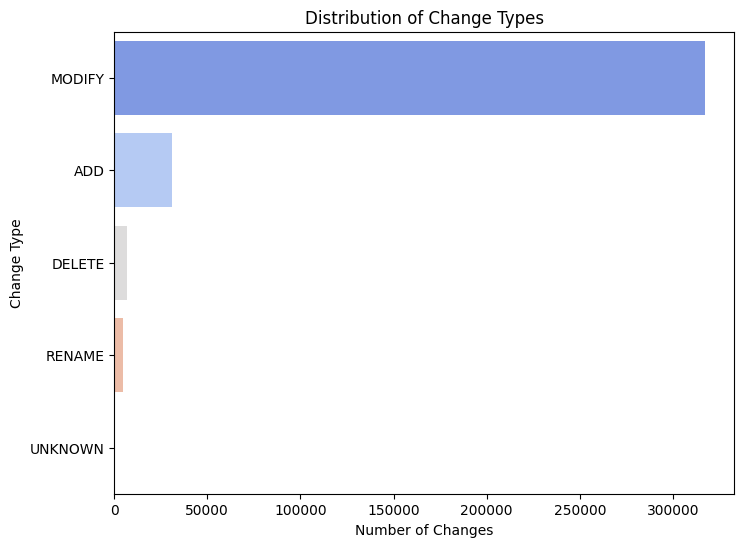

In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns

def plot_change_types(df):
    """
    Plots the distribution of change types (e.g., MODIFY, ADD, DELETE).
    """
    change_types = df['mods'].apply(lambda mods: [mod['change_type'] for mod in mods]).explode().value_counts()
    
    plt.figure(figsize=(8,6))
    sns.barplot(x=change_types.values, y=change_types.index, palette='coolwarm')
    plt.title('Distribution of Change Types')
    plt.xlabel('Number of Changes')
    plt.ylabel('Change Type')
    plt.show()

plot_change_types(df) # We have a lot of MODIFY changes, ADD and DELETE are less frequent

/var/folders/ns/0spd8fg95tv2s7hys988_pb00000gp/T/ipykernel_57045/761037605.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='deep')


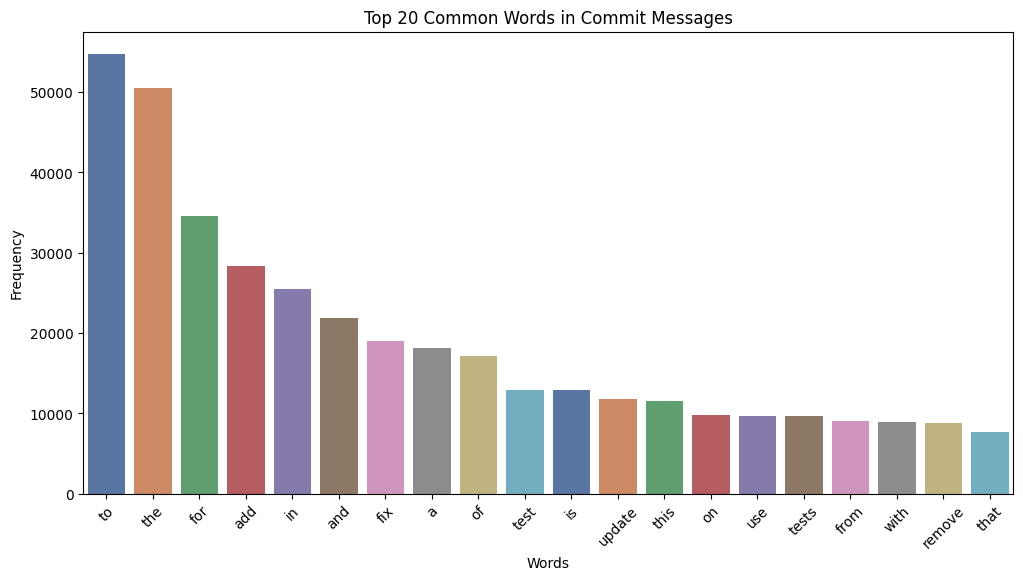

/var/folders/ns/0spd8fg95tv2s7hys988_pb00000gp/T/ipykernel_57045/761037605.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='deep')


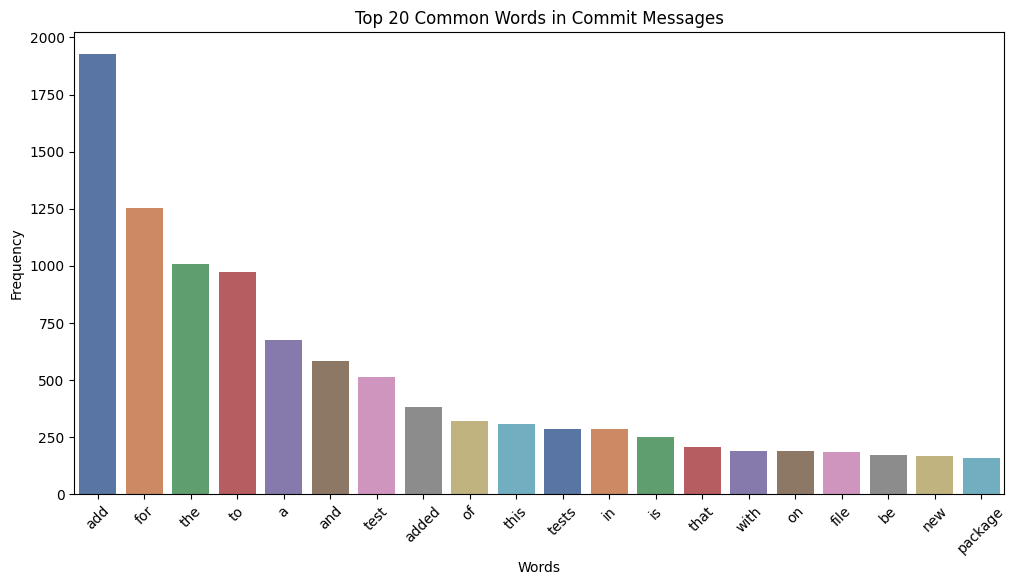

In [23]:
from collections import Counter
import string

def analyze_commit_messages(df):
    """
    Analyzes and plots the most common words in commit messages.
    """
    # Combine all messages
    all_messages = ' '.join(df['message'].dropna().tolist())
    
    # Remove punctuation
    all_messages = all_messages.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize and count
    words = all_messages.lower().split()
    common_words = Counter(words).most_common(20)
    
    # Plot
    words, counts = zip(*common_words)
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(words), y=list(counts), palette='deep')
    plt.title('Top 20 Common Words in Commit Messages')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

analyze_commit_messages(df)
analyze_commit_messages(add_changes_df)

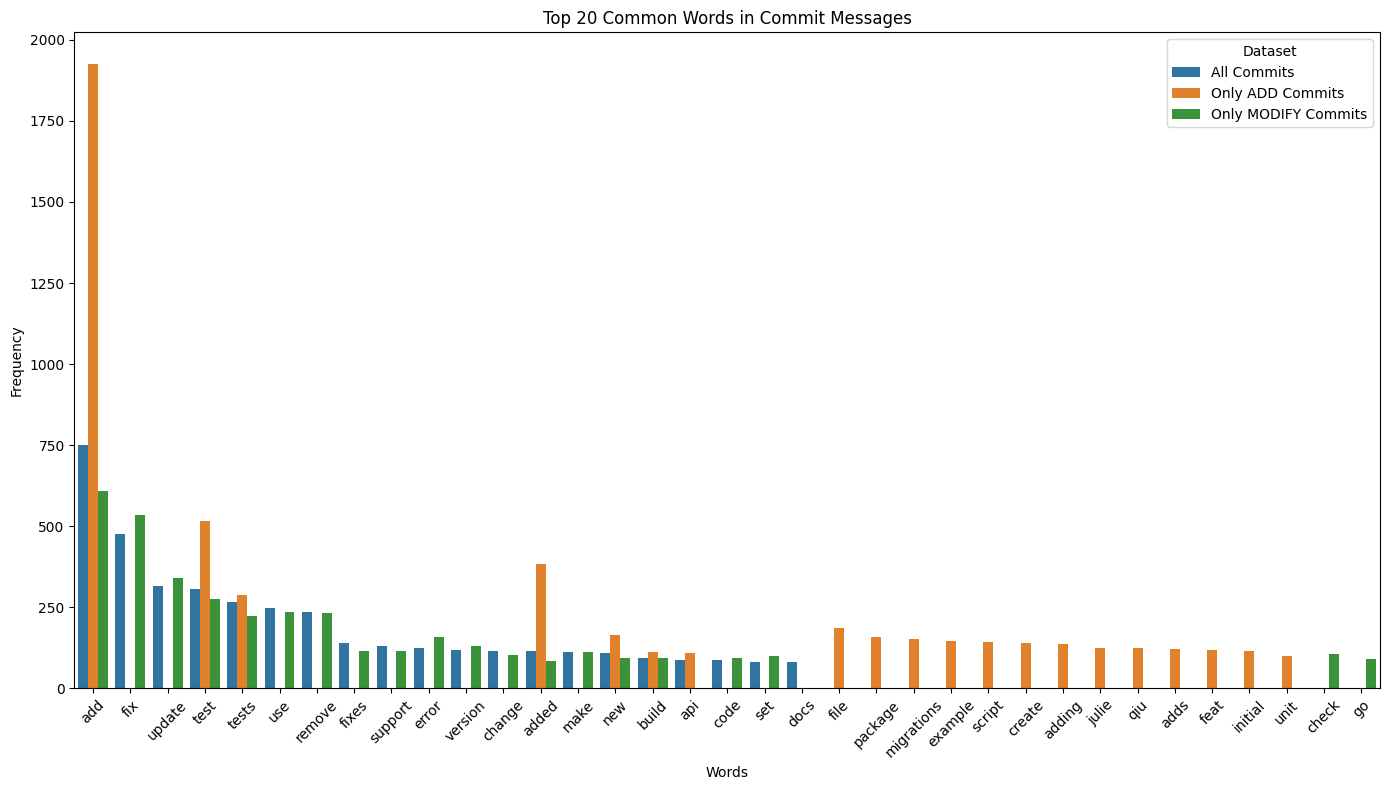

In [31]:
import pandas as pd
import numpy as np
import nltk

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    stopwords_list = nltk.corpus.stopwords.words('english')
    stop_words = set(stopwords_list)
    cleaned_words = [word for word in words if word not in stop_words]
    
    return cleaned_words

def get_word_counts(df):
    all_words = []
    for message in df['message'].dropna():
        all_words.extend(preprocess_text(message))
    return Counter(all_words)

word_counts_original = get_word_counts(df.sample(len(add_changes_df))) # sample the same number of ADD changes to get a good idea
word_counts_add = get_word_counts(add_changes_df)
word_counts_modify = get_word_counts(modify_changes_df.sample(len(add_changes_df)))

def counter_to_df(counter, title):
    df = pd.DataFrame(counter.most_common(20), columns=['word', 'count'])
    df['dataset'] = title
    return df

df_original_words = counter_to_df(word_counts_original, 'All Commits')
df_add_words = counter_to_df(word_counts_add, 'Only ADD Commits')
df_modify_words = counter_to_df(word_counts_modify, 'Only MODIFY Commits')

df_combined = pd.concat([df_original_words, df_add_words, df_modify_words])

plt.figure(figsize=(14, 8))
sns.barplot(data=df_combined, x='word', y='count', hue='dataset')

plt.title('Top 20 Common Words in Commit Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() # We can see there is a difference between the most common words in ADD and MODIFY commits
            # It's supported by the fact that MODIFY commits are more similar to the original commits as they are more frequent


In [28]:
from scipy.stats import entropy
vocabulary = set(word_counts_original.keys()).union(set(word_counts_add.keys()))

counts_original = []
counts_add = []

for word in vocabulary:
    counts_original.append(word_counts_original.get(word, 0))
    counts_add.append(word_counts_add.get(word, 0))

counts_original = np.array(counts_original, dtype=np.float64)
counts_add = np.array(counts_add, dtype=np.float64)

epsilon = 1e-10 
counts_original += epsilon
counts_add += epsilon

prob_original = counts_original / counts_original.sum()
prob_add = counts_add / counts_add.sum()

kl_divergence = entropy(prob_original, prob_add)

print(f"KL Divergence (All Commits || Only ADD Commits): {kl_divergence:.4f}")

kl_divergence_reverse = entropy(prob_add, prob_original)
print(f"KL Divergence (Only ADD Commits || All Commits): {kl_divergence_reverse:.4f}")

KL Divergence (All Commits || Only ADD Commits): 5.6793
KL Divergence (Only ADD Commits || All Commits): 4.5922


Higher values for the KL Divergence (non-zero) indicate strong differences between both distributions

## Preprocessing

Columns of interest in the dataset are:
1. `mods` - Contains all file changes information - what files are changed, the type of change made (addition, modification), and the exact file changes.
2. `message` - The (processed) git commit message
3. `author` - (Optional) This will be used if we want to group commits by a certain author and use that as input. This is and advanced use case

We are going to tokenize the `mods` and `message` using two different tokenizer, since `mods` contains code and which is quite different from `message` which is mostly natural language. So, one tokenizer for `mods`, another for `message`.

We'll start with `message`. The output from the tokenization of  `message` will be called `msg_input_ids`.

Note: All the preprocessing logic explored here is implemented in `CommitChroniclePreprocessor`.

In [36]:
from src.data.components.tokenization import add_special_tokens
from transformers import AutoTokenizer

# This is the tokenizer used in the Commit Chronicle dataset
# The rationale behind this choice is yet to be investigated? Someone could investigate and report :)
# OR we may have to train our own tokenizer as suggested by our all-knowing ChatGPT (https://chatgpt.com/share/672e3b64-6b84-8009-a6c9-adac73cf647e)
msg_tokenizer_ = AutoTokenizer.from_pretrained("Salesforce/codet5-base")

# add `sep_token` and `pad_token`
# `sep_token` is necessary when we are training on a history of git diffs (which is an advanced usage and not part of our initial experiments)
# `pad_token` is necessary for correct batch construction.
msg_tokenizer_ = add_special_tokens(msg_tokenizer_, None)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Let's try out commit message tokenization on a single example

In [37]:
msg_input_ids_ = msg_tokenizer_(
    dataset[0]["message"], truncation=False, padding=False, add_special_tokens=False
).input_ids

print(dataset[0]["message"])
print(msg_input_ids_)

Add code to retrieve the correct user directory on windows and linux ... and a somewhat okayish directory on macos"
[986, 981, 358, 4614, 326, 3434, 729, 1867, 603, 9965, 471, 19725, 1372, 471, 279, 18016, 11304, 21194, 1468, 1867, 603, 5318, 538, 6]


Next, we'll look at the tokenization of git commit changes, `mods`. But before we do that, let's examine the structure of the data.

In [38]:
dataset[0]["mods"]

[{'change_type': 'ADD',
  'old_path': None,
  'new_path': 'internal/config/config.go',
  'diff': '+package config\n+\n+import "strings"\n+\n+var (\n+ //AppName is the name representing the application.\n+ AppName = "Cordless"\n+ //AppNameLowercase is the representative name, but lowercase.\n+ //It us used for filepaths and such.\n+ AppNameLowercase = strings.ToLower(AppName)\n+)\n+\n+//Config contains all possible configuration for the application.\n+type Config struct {\n+ Token string\n+}\n+\n+var cachedConfigDir string\n+\n+//GetConfigDirectory is the parent directory in the os, that contains the\n+//settings for the application.\n+func GetConfigDirectory() (string, error) {\n+ if cachedConfigDir != "" {\n+ return cachedConfigDir, nil\n+ }\n+\n+ directory, err := getConfigDirectory()\n+ if err != nil {\n+ return "", err\n+ }\n+\n+ cachedConfigDir = directory\n+ return cachedConfigDir, nil\n+}\n'},
 {'change_type': 'ADD',
  'old_path': None,
  'new_path': 'internal/config/os_darwin.g

We'll need to somehow combine all that information into a single string before tokenization.

In [39]:
def preprocess_mods(mods: list[dict[str, str]], line_sep: str) -> str:
    """
    Transforms a list of all files modifications made in a commit into a single string representation.

    Specifically, adds a header to each file diff (https://git-scm.com/docs/git-diff#_generating_patch_text_with_p)
    and concatenates the results.

    Args:
        mods: A list of files modifications made in a commit.
        line_sep: The line separator to separate each file modification.

    Returns:
        A single string representation of all files modifications made in a commit.
    """
    diff = ""

    for mod in mods:
        if mod["change_type"] == "UNKNOWN":
            continue
        elif mod["change_type"] == "ADD":
            file_diff = f"new file {mod['new_path']}"
        elif mod["change_type"] == "DELETE":
            file_diff = f"deleted file {mod['old_path']}"
        elif mod["change_type"] == "RENAME":
            file_diff = (
                f"rename from {mod['old_path']}{line_sep}rename to {mod['new_path']}"
            )
        elif mod["change_type"] == "COPY":
            file_diff = (
                f"copy from {mod['old_path']}{line_sep}copy to {mod['new_path']}"
            )
        else:
            file_diff = f"{mod['new_path']}"
        diff += file_diff + line_sep + mod["diff"]

    return diff


# Let's test it out
print(preprocess_mods(dataset[0]["mods"], line_sep="\n"))

new file internal/config/config.go
+package config
+
+import "strings"
+
+var (
+ //AppName is the name representing the application.
+ AppName = "Cordless"
+ //AppNameLowercase is the representative name, but lowercase.
+ //It us used for filepaths and such.
+ AppNameLowercase = strings.ToLower(AppName)
+)
+
+//Config contains all possible configuration for the application.
+type Config struct {
+ Token string
+}
+
+var cachedConfigDir string
+
+//GetConfigDirectory is the parent directory in the os, that contains the
+//settings for the application.
+func GetConfigDirectory() (string, error) {
+ if cachedConfigDir != "" {
+ return cachedConfigDir, nil
+ }
+
+ directory, err := getConfigDirectory()
+ if err != nil {
+ return "", err
+ }
+
+ cachedConfigDir = directory
+ return cachedConfigDir, nil
+}
new file internal/config/os_darwin.go
+package config
+
+import (
+ "os/user"
+ "path/filepath"
+)
+
+func getConfigDirectory() (string, error) {
+ //TODO Gotta research this
+
+ currentU

Now onto tokenization of the concatenated git diff or `mods`

In [40]:
from copy import deepcopy

# Here, we just duplicate the message tokenizer, but it could be completely different, or maybe I lied :)
diff_tokenizer_ = deepcopy(msg_tokenizer_)
# diff can be very long, we need to set a limit that our model (and computer resources) can handle
DIFF_MAX_LEN = 512

# again, let's test it
git_diff_ = preprocess_mods(dataset[0]["mods"], line_sep="\n")
diff_input_ids_ = diff_tokenizer_(
    git_diff_,
    truncation=True,
    max_length=DIFF_MAX_LEN
    - 2,  # -2 to account for special tokens (BOS and EOS) to be added later, during batch data construction.
    padding=False,
    add_special_tokens=False,
).input_ids
print(diff_input_ids_[:100], len(diff_input_ids_))

[2704, 585, 2713, 19, 1425, 19, 1425, 18, 3240, 203, 15, 5610, 642, 203, 15, 203, 15, 5666, 315, 10219, 6, 203, 15, 203, 15, 1401, 261, 203, 15, 368, 3371, 461, 353, 326, 508, 5123, 326, 2521, 18, 203, 15, 4677, 461, 273, 315, 39, 517, 2656, 6, 203, 15, 368, 3371, 461, 4070, 3593, 353, 326, 23174, 508, 16, 1496, 12400, 18, 203, 15, 368, 7193, 584, 1399, 364, 3608, 87, 471, 4123, 18, 203, 15, 4677, 461, 4070, 3593, 273, 2064, 18, 774, 4070, 12, 3371, 461, 13, 203, 6975, 203, 15, 203, 15, 759, 809, 1914] 510


Let's put everything together to process `mods` and `message` columns for all rows in the dataset.

In [41]:
def process_example(
    example,
    msg_tokenizer,
    diff_tokenizer,
    diff_max_len,
    diff_line_sep,
    preprocess_mods_func,
):
    msg_input_ids = msg_tokenizer(
        example["message"], truncation=False, padding=False, add_special_tokens=False
    ).input_ids

    git_diff = preprocess_mods_func(example["mods"], line_sep=diff_line_sep)
    diff_input_ids = diff_tokenizer(
        git_diff,
        truncation=True,  # we unfortunately have to truncate the git changes
        max_length=diff_max_len
        - 2,  # -2 to account for special tokens (BOS and EOS) to be added later, during batch data construction.
        padding=False,
        add_special_tokens=False,
    ).input_ids

    return {
        "author": example["author"],
        "message": example["message"],
        "msg_input_ids": msg_input_ids,
        "diff_input_ids": diff_input_ids,
        "repo": example["repo"],
        "language": example["language"],
    }


processed = OUTPUT_DIR / "02-processed"
if not processed.exists():
    (
        dataset.map(
            partial(
                process_example,
                msg_tokenizer=msg_tokenizer_,
                diff_tokenizer=diff_tokenizer_,
                diff_max_len=DIFF_MAX_LEN,
                diff_line_sep="\n",
                preprocess_mods_func=preprocess_mods,
            ),
            num_proc=mp.cpu_count(),
        )
        .select_columns(
            ["author", "msg_input_ids", "diff_input_ids", "language", "repo"]
        )
        .save_to_disk(processed)
    )
dataset = load_from_disk(processed)

Map (num_proc=11):   0%|          | 0/133954 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/133954 [00:00<?, ? examples/s]

In [42]:
dataset.select(range(10))

Dataset({
    features: ['author', 'msg_input_ids', 'diff_input_ids', 'language', 'repo'],
    num_rows: 10
})